In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import datetime
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

from einops import rearrange

#PyTorch random number generator
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [2]:
bc_fine = np.zeros(((45, 168, 4)))

for i in range (45):
    df1 = pd.read_csv('C:/Users/59713/BC2MAP/inputs/case_{}.csv'.format(i+1))
    data1 = df1.values
    bc_fine[i, :, :] = data1

In [3]:
D_3d_fine = np.zeros(((45, 576, 384)))

for i in range (45):
    df2 = pd.read_csv('C:/Users/59713/BC2MAP/Saved data/fine_{}.csv'.format(i))
    data2 = df2.values
    D_3d_fine[i, :, :] = np.reshape(data2[:, 5], (576, 384))

In [4]:
E_3d_fine = np.zeros((576, 384))
X_3d_fine = np.zeros((576, 384))
Y_3d_fine = np.zeros((576, 384))
S_3d_fine = np.zeros((576, 384))
map4all = np.zeros((576, 384))

df3 = pd.read_csv('C:/Users/59713/BC2MAP/Saved data/fine_45.csv')
data3 = df3.values
X_3d_fine[:, :] = np.reshape(data3[:, 0], (576, 384))
Y_3d_fine[:, :] = np.reshape(data3[:, 1], (576, 384))
E_3d_fine[:, :] = np.reshape(data3[:, 3], (576, 384))
map4all[:, :] = np.reshape(data3[:, 5], (576, 384))

In [5]:
dzdx = np.zeros((576, 384))
dzdy = np.zeros((576, 384))

# calculate internal cell slope
for i in range (1, S_3d_fine.shape[0]-1):
    for j in range (1, S_3d_fine.shape[1]-1):
        dzdx[i, j] = ((E_3d_fine[i+1, j-1]+2*E_3d_fine[i+1, j]+E_3d_fine[i+1, j+1]) - (E_3d_fine[i-1, j-1]+E_3d_fine[i-1, j]+2*E_3d_fine[i-1, j+1]))/(8*(X_3d_fine[i+1, j]-X_3d_fine[i-1, j]))
        dzdy[i, j] = ((E_3d_fine[i-1, j+1]+2*E_3d_fine[i, j+1]+E_3d_fine[i+1, j+1]) - (E_3d_fine[i-1, j-1]+E_3d_fine[i, j-1]+2*E_3d_fine[i+1, j-1]))/(8*(Y_3d_fine[i, j+1]-Y_3d_fine[i, j-1]))
        S_3d_fine[i, j] = np.arctan(np.sqrt((dzdx[i, j])**2+(dzdy[i, j])**2))
        
# take care of the most oustside layer
S_3d_fine[0, :] = S_3d_fine[1, :]
S_3d_fine[-1, :] = S_3d_fine[-2, :]
S_3d_fine[:, 0] = S_3d_fine[:, 1]
S_3d_fine[:, -1] = S_3d_fine[:, -2]

### make a 3D info

In [6]:
all_data_X = bc_fine
all_data_Y = D_3d_fine

In [7]:
print(all_data_X.shape, all_data_Y.shape)

(45, 168, 4) (45, 576, 384)


In [8]:
# split into train and test
train_X, test_X = all_data_X[:-5, :], all_data_X[-5:, :]
train_y, test_y = all_data_Y[:-5, :, :], all_data_Y[-5:, :, :]

In [9]:
batch_size = 1

train_features = torch.Tensor(train_X).to(device)
train_targets = torch.Tensor(train_y).to(device)
test_features = torch.Tensor(test_X).to(device)
test_targets = torch.Tensor(test_y).to(device)

train = TensorDataset(train_features, train_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [10]:
sup_feat = np.zeros(((batch_size, 3, 576, 384)))

# first channel is mapforall
sup_feat[:, 0, :, :] = map4all
# second channel is elevation
sup_feat[:, 1, :, :] = E_3d_fine
# third channel is slope
sup_feat[:, 2, :, :] = S_3d_fine
# fourth channel left for bc info after SA


In [11]:
class Self_Attention(nn.Module):
    def __init__(self):
        super(Self_Attention, self).__init__()
        
        self.embed_dim = 864
        self.num_heads = 1
        self.head_dim = self.embed_dim // self.num_heads
        
        self.value = nn.Linear(self.embed_dim, self.embed_dim)
        self.key = nn.Linear(self.embed_dim, self.embed_dim)
        self.query = nn.Linear(self.embed_dim, self.embed_dim)
                    
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        
        batch_size, seq_len, embed_dim = x.size()
        # Reshape query, key, and value to split into multiple heads
        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose to prepare for scaled dot-product attention
        queries = queries.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        keys = keys.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        values = values.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # Apply softmax to get attention probabilities
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (self.head_dim**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        
        # Compute the weighted sum of values
        x = torch.matmul(attention_probs, values)
        
        # Reshape and concatenate heads
        x = x.transpose(1, 2)
        
        out = x.reshape(x.size(0), seq_len, embed_dim)
        
        return out

In [12]:
class BC2Map(nn.Module):
    def __init__(self, input_size, output_size, background_map, batch_size):
        super(BC2Map, self).__init__()
        
        self.background_map = torch.Tensor(background_map).to(device)
        
        self.input_size = input_size
        self.hidden_dim = output_size
        batch_size = batch_size
                
        self.fc1 = nn.Linear(input_size*3, self.hidden_dim)
        self.fc2 = nn.Linear(input_size, self.hidden_dim)
        
        self.self_attention = Self_Attention().to(device)
        
        self.L1 = nn.Linear(864, 4096)
        self.L2 = nn.Linear(4096, 864)
        
        self.pos_embedding = nn.Parameter(data=torch.randn(1, 2, 576, 384)).to(device)
        
        ##-----------end of embedding ---------##
        ##-----------start of Unet ---------##
        
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv_transpose0 = nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=2, stride=2, padding=0)
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0)
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.conv_transpose3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.conv_transpose4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.conv_transpose5 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        # change dimension, maybe it's better to use embedding
        x = x.transpose(1, 2)
        x1 = x[:, :3, :].reshape(x.size(0), 1, -1)
        x1 = self.relu(self.fc1(x1))
        x2 = x[:, 3:, :]
        x2 = self.relu(self.fc2(x2))
        
        x = torch.cat((x1, x2), dim=1)
        x = rearrange(x, 'b c (h w) -> b c h w', h=576)
        
        # add positional embeddings
        x = x + self.pos_embedding
        
        x = rearrange(x, 'b c (h1 h) (w1 w) -> b (c h1 w1) (h w)', h1=16, w1=16)
        
        # Self-Attention #1
        x = self.self_attention(x)
        
        # Concat the full feature map
        x = rearrange(x, 'b (c h1 w1) (h w) -> b c (h1 h) (w1 w)', h1=16, w1=16, c=2, h=36, w=24)
        x = torch.cat((x, self.background_map), dim=1)
        
        # initial conv: 1->64
        x = self.relu(self.conv1(x))
        
        # 1st resblock: 64->64
        identity = x
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = x + identity
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 2nd resblock: 64->128
        identity2 = x
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        identity2 = self.conv3(identity2)
        x = x + identity2
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 3rd resblock: 128->256
        identity3 = x
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        identity3 = self.conv5(identity3)
        x = x + identity3
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 4th resblock: 256->512
        identity4 = x
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        identity4 = self.conv7(identity4)
        x = x + identity4
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 5th resblock: 512->1024
        identity5 = x
        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        identity5 = self.conv9(identity5)
        x = x + identity5
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 5th resblock: 1024->2048
        x = self.conv12(self.relu(self.conv11(x))) + self.conv11(x)
        x = self.relu(x)
        
        # transpose0: 2048->1024
        x = self.relu(self.conv_transpose0(x))
        x = self.conv10(self.relu(self.conv10(x))) + x
        x = self.relu(x)
        
        # transpose0: 1024->512
        x = self.relu(self.conv_transpose1(x))
        x = self.conv8(self.relu(self.conv8(x))) + x
        x = self.relu(x)
        
        # transpose1: 512->256
        x = self.relu(self.conv_transpose2(x))
        x = self.conv6(self.relu(self.conv6(x))) + x
        x = self.relu(x)
        
        # transpose2: 256->128
        x = self.relu(self.conv_transpose3(x))
        x = self.conv4(self.relu(self.conv4(x))) + x
        x = self.relu(x)
        
        # transpose3: 128->64
        x = self.relu(self.conv_transpose4(x))
        x = self.conv2(self.relu(self.conv2(x))) + x
        x = self.relu(x)
        
        # transpose4: 64->1
        x = self.relu(self.conv_transpose5(x))
        
        out = x.reshape(x.size(0), -1)
        
        return out

In [13]:
class Optimization:
    def __init__(self, model, optimizer):
        self.model = model
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=4, n_epochs=50):
        model_path = f'models/{self.model}_{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.view([batch_size, 576*384]).to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.view([batch_size, 576*384]).to(device)
                    self.model.eval()
                    yhat = self.model(x_val).to(device)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.6f}\t Validation loss: {validation_loss:.6f}"
                )
            
            if (validation_loss <= 0.0045):
                break

#         torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.view([batch_size, 576*384]).to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[5/5000] Training loss: 6.130342	 Validation loss: 6.594026
[10/5000] Training loss: 5.588897	 Validation loss: 6.374177
[15/5000] Training loss: 4.129445	 Validation loss: 2.783890
[20/5000] Training loss: 0.282548	 Validation loss: 0.403056
[25/5000] Training loss: 0.099198	 Validation loss: 0.271408
[30/5000] Training loss: 0.066284	 Validation loss: 0.268734
[35/5000] Training loss: 0.057439	 Validation loss: 0.259666
[40/5000] Training loss: 0.054695	 Validation loss: 0.273571
[45/5000] Training loss: 0.051198	 Validation loss: 0.276493
[50/5000] Training loss: 0.056032	 Validation loss: 0.272423
[55/5000] Training loss: 0.053004	 Validation loss: 0.280553
[60/5000] Training loss: 0.057326	 Validation loss: 0.266749
[65/5000] Training loss: 0.074931	 Validation loss: 0.445246
[70/5000] Training loss: 0.462194	 Validation loss: 0.350323
[75/5000] Training loss: 0.109208	 Validation loss: 0.175608
[80/5000] Training loss: 0.105611	 Validation loss: 0.160686
[85/5000] Training loss: 

[670/5000] Training loss: 0.046811	 Validation loss: 0.121219
[675/5000] Training loss: 0.044742	 Validation loss: 0.096666
[680/5000] Training loss: 0.040318	 Validation loss: 0.089904
[685/5000] Training loss: 0.102978	 Validation loss: 1.647121
[690/5000] Training loss: 0.045918	 Validation loss: 0.090871
[695/5000] Training loss: 0.042722	 Validation loss: 0.095129
[700/5000] Training loss: 0.042331	 Validation loss: 0.094647
[705/5000] Training loss: 0.041436	 Validation loss: 0.094468
[710/5000] Training loss: 0.041170	 Validation loss: 0.093214
[715/5000] Training loss: 0.041865	 Validation loss: 0.096085
[720/5000] Training loss: 0.041751	 Validation loss: 0.094859
[725/5000] Training loss: 0.042625	 Validation loss: 0.092983
[730/5000] Training loss: 0.040784	 Validation loss: 0.091110
[735/5000] Training loss: 0.040532	 Validation loss: 0.090505
[740/5000] Training loss: 0.040402	 Validation loss: 0.092111
[745/5000] Training loss: 0.040179	 Validation loss: 0.093139
[750/500

[1330/5000] Training loss: 0.004984	 Validation loss: 0.021578
[1335/5000] Training loss: 0.006099	 Validation loss: 0.023448
[1340/5000] Training loss: 0.015223	 Validation loss: 0.023443
[1345/5000] Training loss: 0.006097	 Validation loss: 0.021285
[1350/5000] Training loss: 0.005743	 Validation loss: 0.025116
[1355/5000] Training loss: 0.005670	 Validation loss: 0.021620
[1360/5000] Training loss: 0.004866	 Validation loss: 0.021599
[1365/5000] Training loss: 0.004971	 Validation loss: 0.025031
[1370/5000] Training loss: 0.005709	 Validation loss: 0.025147
[1375/5000] Training loss: 0.005070	 Validation loss: 0.022777
[1380/5000] Training loss: 0.004824	 Validation loss: 0.022456
[1385/5000] Training loss: 0.005167	 Validation loss: 0.021957
[1390/5000] Training loss: 0.004685	 Validation loss: 0.021170
[1395/5000] Training loss: 0.005400	 Validation loss: 0.024155
[1400/5000] Training loss: 0.005225	 Validation loss: 0.021432
[1405/5000] Training loss: 0.007505	 Validation loss: 0

[1985/5000] Training loss: 0.003170	 Validation loss: 0.014529
[1990/5000] Training loss: 0.002971	 Validation loss: 0.015540
[1995/5000] Training loss: 0.004388	 Validation loss: 0.013908
[2000/5000] Training loss: 0.003249	 Validation loss: 0.013675
[2005/5000] Training loss: 0.003117	 Validation loss: 0.015214
[2010/5000] Training loss: 0.002968	 Validation loss: 0.013246
[2015/5000] Training loss: 0.003249	 Validation loss: 0.015125
[2020/5000] Training loss: 0.003161	 Validation loss: 0.013292
[2025/5000] Training loss: 0.002843	 Validation loss: 0.013342
[2030/5000] Training loss: 0.016469	 Validation loss: 0.030310
[2035/5000] Training loss: 0.004587	 Validation loss: 0.016007
[2040/5000] Training loss: 0.009096	 Validation loss: 0.021891
[2045/5000] Training loss: 0.004061	 Validation loss: 0.013192
[2050/5000] Training loss: 0.008139	 Validation loss: 0.018285
[2055/5000] Training loss: 0.003388	 Validation loss: 0.013734
[2060/5000] Training loss: 0.002899	 Validation loss: 0

[2640/5000] Training loss: 0.001753	 Validation loss: 0.011989
[2645/5000] Training loss: 0.001520	 Validation loss: 0.011495
[2650/5000] Training loss: 0.001541	 Validation loss: 0.011082
[2655/5000] Training loss: 0.002020	 Validation loss: 0.011668
[2660/5000] Training loss: 0.002328	 Validation loss: 0.010002
[2665/5000] Training loss: 0.001433	 Validation loss: 0.011055
[2670/5000] Training loss: 0.001366	 Validation loss: 0.010816
[2675/5000] Training loss: 0.002240	 Validation loss: 0.009829
[2680/5000] Training loss: 0.001853	 Validation loss: 0.014357
[2685/5000] Training loss: 0.001614	 Validation loss: 0.014253
[2690/5000] Training loss: 0.003476	 Validation loss: 0.014208
[2695/5000] Training loss: 0.001969	 Validation loss: 0.012061
[2700/5000] Training loss: 0.001431	 Validation loss: 0.010721
[2705/5000] Training loss: 0.001364	 Validation loss: 0.010330
[2710/5000] Training loss: 0.001348	 Validation loss: 0.010410
[2715/5000] Training loss: 0.001300	 Validation loss: 0

[3295/5000] Training loss: 0.001484	 Validation loss: 0.009288
[3300/5000] Training loss: 0.001117	 Validation loss: 0.008567
[3305/5000] Training loss: 0.000982	 Validation loss: 0.008829
[3310/5000] Training loss: 0.000985	 Validation loss: 0.008262
[3315/5000] Training loss: 0.000977	 Validation loss: 0.009108
[3320/5000] Training loss: 0.001348	 Validation loss: 0.008702
[3325/5000] Training loss: 0.004040	 Validation loss: 0.009950
[3330/5000] Training loss: 0.002810	 Validation loss: 0.010327
[3335/5000] Training loss: 0.001315	 Validation loss: 0.010923
[3340/5000] Training loss: 0.001146	 Validation loss: 0.010086
[3345/5000] Training loss: 0.001123	 Validation loss: 0.008822
[3350/5000] Training loss: 0.000979	 Validation loss: 0.009265
[3355/5000] Training loss: 0.000937	 Validation loss: 0.009340
[3360/5000] Training loss: 0.001677	 Validation loss: 0.007278
[3365/5000] Training loss: 0.001328	 Validation loss: 0.008870
[3370/5000] Training loss: 0.000983	 Validation loss: 0

[3950/5000] Training loss: 0.001765	 Validation loss: 0.007910
[3955/5000] Training loss: 0.001275	 Validation loss: 0.007415
[3960/5000] Training loss: 0.000718	 Validation loss: 0.007347
[3965/5000] Training loss: 0.000702	 Validation loss: 0.007395
[3970/5000] Training loss: 0.000683	 Validation loss: 0.007650
[3975/5000] Training loss: 0.000750	 Validation loss: 0.007581
[3980/5000] Training loss: 0.000780	 Validation loss: 0.007608
[3985/5000] Training loss: 0.001610	 Validation loss: 0.007256
[3990/5000] Training loss: 0.001242	 Validation loss: 0.007754
[3995/5000] Training loss: 0.000880	 Validation loss: 0.007869
[4000/5000] Training loss: 0.000719	 Validation loss: 0.007776
[4005/5000] Training loss: 0.000885	 Validation loss: 0.007721
[4010/5000] Training loss: 0.001259	 Validation loss: 0.010672
[4015/5000] Training loss: 0.000940	 Validation loss: 0.009327
[4020/5000] Training loss: 0.000773	 Validation loss: 0.007925
[4025/5000] Training loss: 0.000768	 Validation loss: 0

[4605/5000] Training loss: 0.000617	 Validation loss: 0.007615
[4610/5000] Training loss: 0.000986	 Validation loss: 0.007660
[4615/5000] Training loss: 0.000588	 Validation loss: 0.007344
[4620/5000] Training loss: 0.000586	 Validation loss: 0.008266
[4625/5000] Training loss: 0.000592	 Validation loss: 0.007549
[4630/5000] Training loss: 0.000573	 Validation loss: 0.007357
[4635/5000] Training loss: 0.000564	 Validation loss: 0.007716
[4640/5000] Training loss: 0.002046	 Validation loss: 0.007623
[4645/5000] Training loss: 0.000712	 Validation loss: 0.006941
[4650/5000] Training loss: 0.000563	 Validation loss: 0.007196
[4655/5000] Training loss: 0.000547	 Validation loss: 0.007386
[4660/5000] Training loss: 0.000553	 Validation loss: 0.007389
[4665/5000] Training loss: 0.000540	 Validation loss: 0.007284
[4670/5000] Training loss: 0.000534	 Validation loss: 0.007086
[4675/5000] Training loss: 0.000540	 Validation loss: 0.007701
[4680/5000] Training loss: 0.000676	 Validation loss: 0

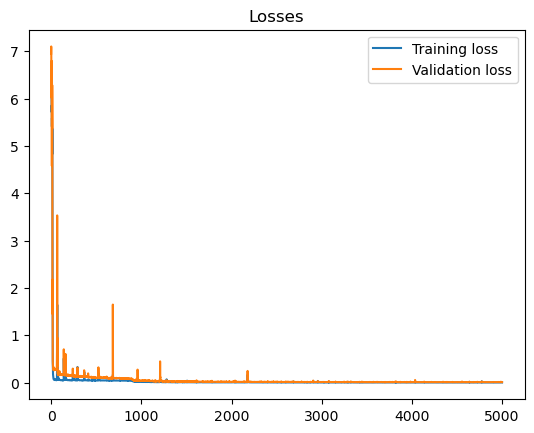

In [14]:
input_size = 672//4
output_size = 576 * 384

batch_size = batch_size
n_epochs = 5000
learning_rate = 1e-4
weight_decay = learning_rate/n_epochs

model = BC2Map(input_size, output_size, background_map=sup_feat, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, optimizer=optimizer)
opt.train(train_loader, test_loader, batch_size=batch_size, n_epochs=n_epochs)
opt.plot_losses()

In [15]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1)

preds = np.array(predictions)
vals = np.array(values)

preds = np.reshape(preds, (5, 576, 384))
vals = np.reshape(vals, (5, 576, 384))

print(preds.shape, vals.shape)

(5, 576, 384) (5, 576, 384)


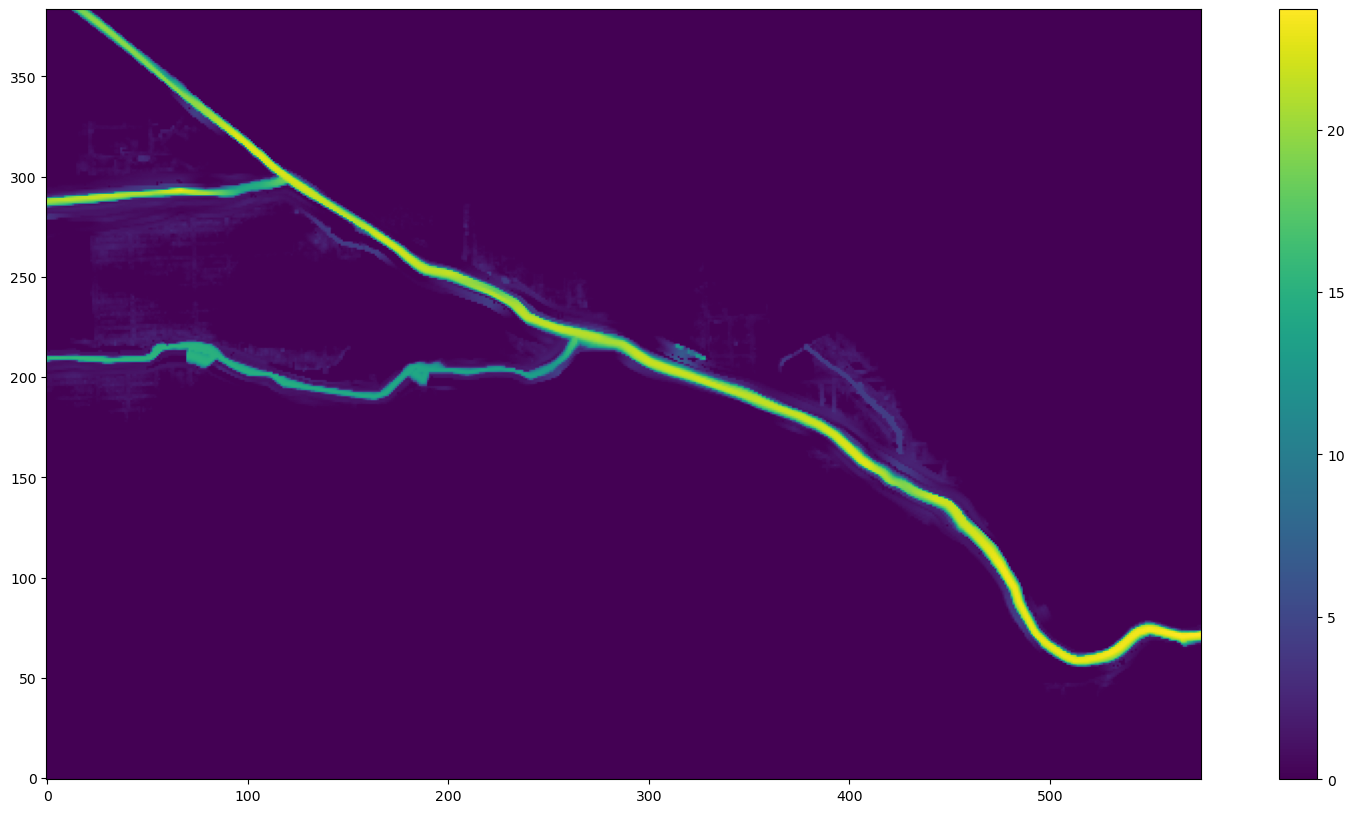

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

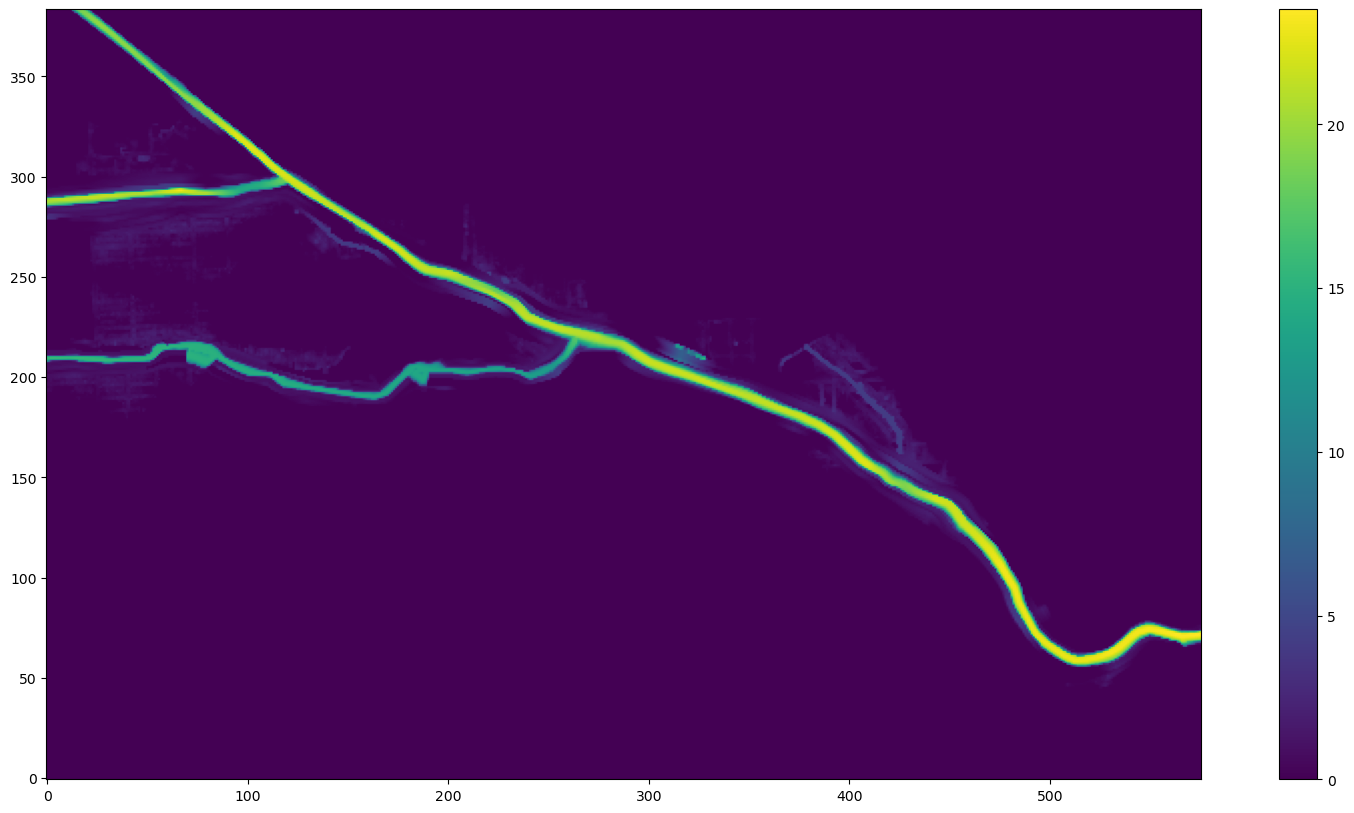

In [17]:
plt.imshow(vals[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

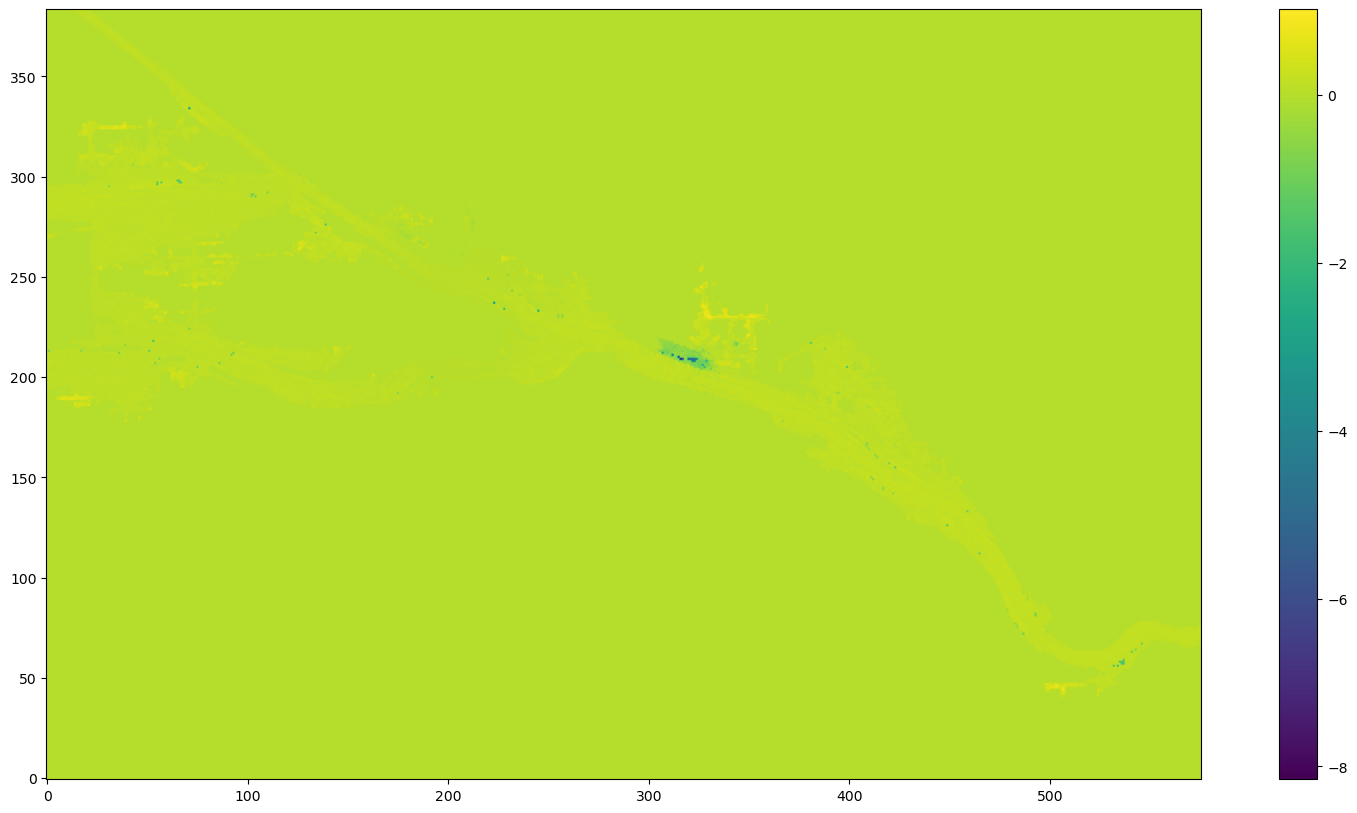

In [18]:
plt.imshow(preds[0, :, :].transpose() - vals[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

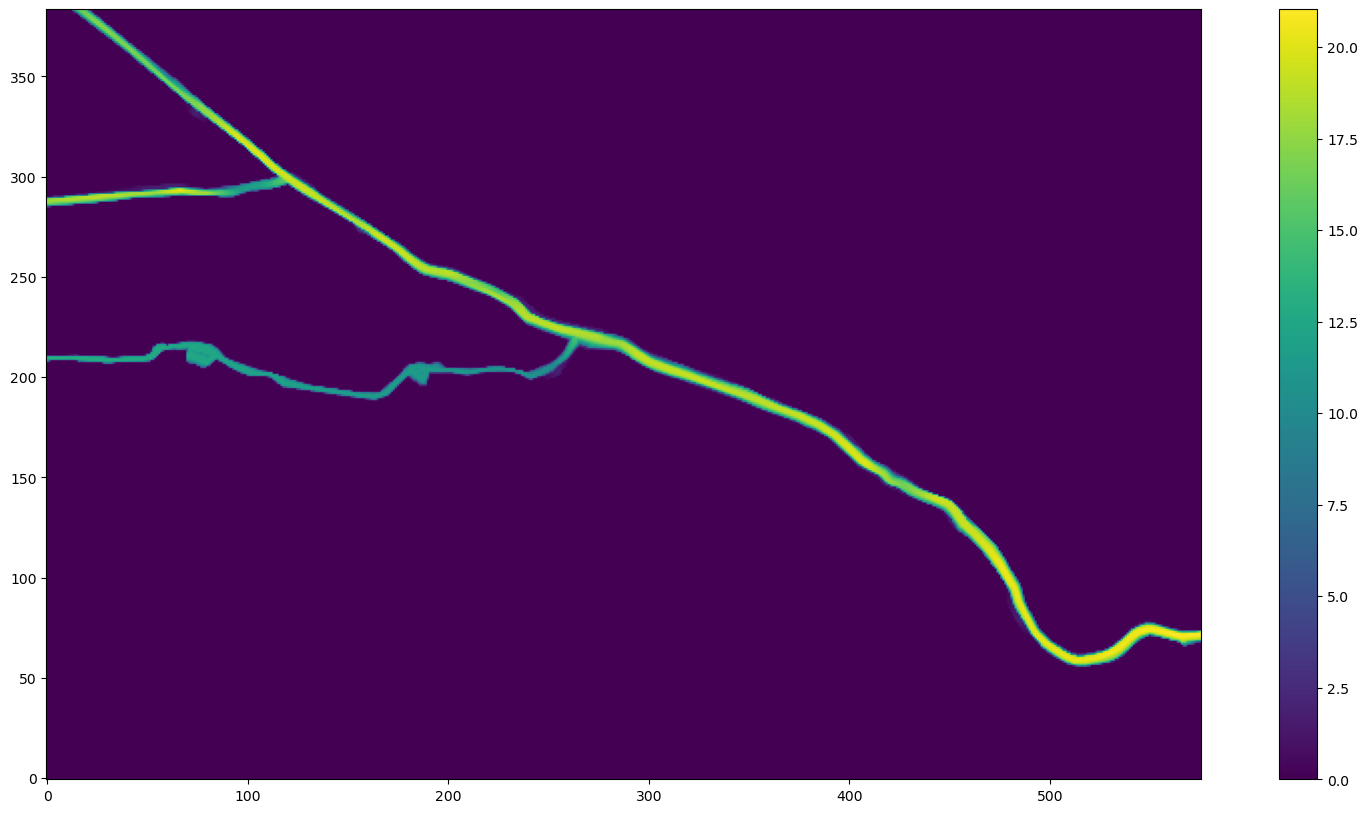

In [19]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

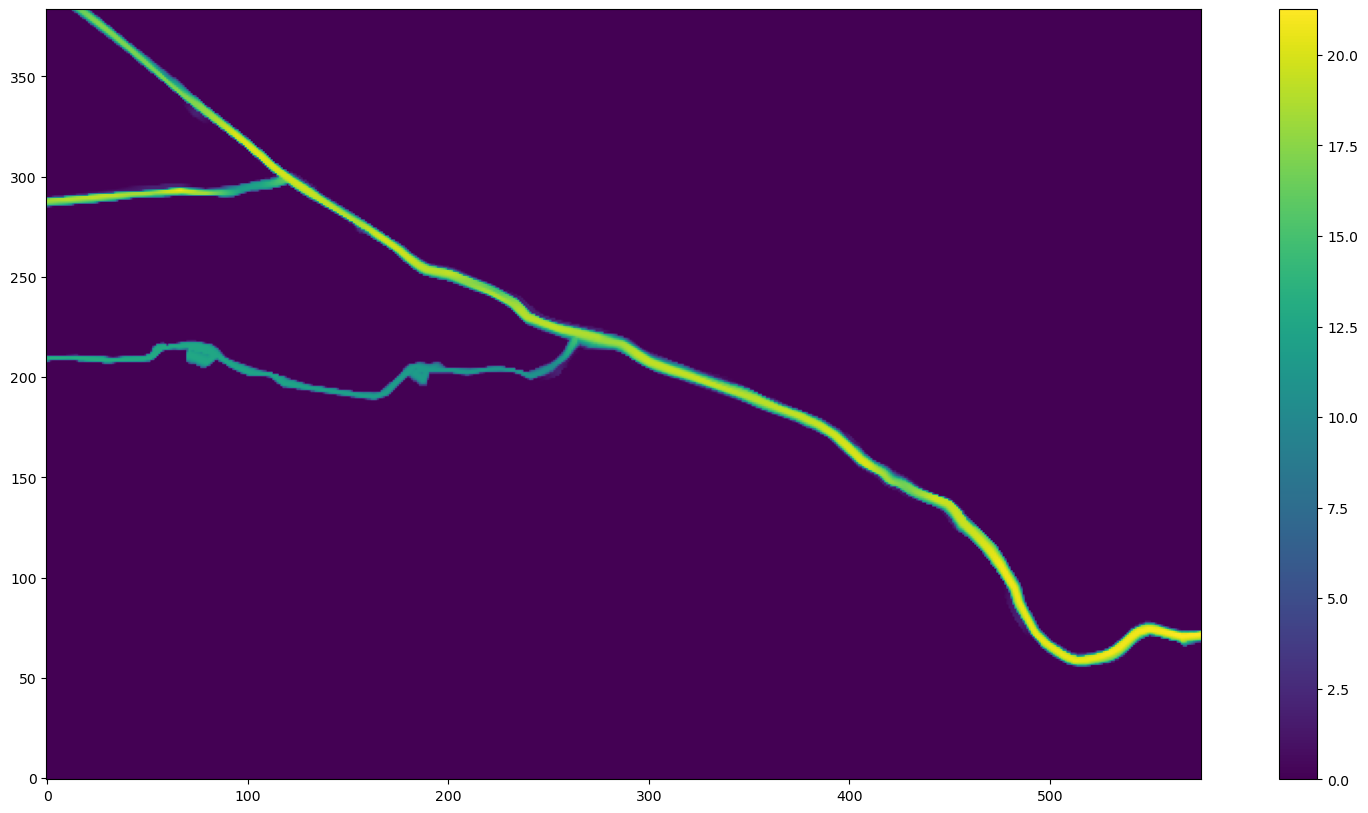

In [20]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

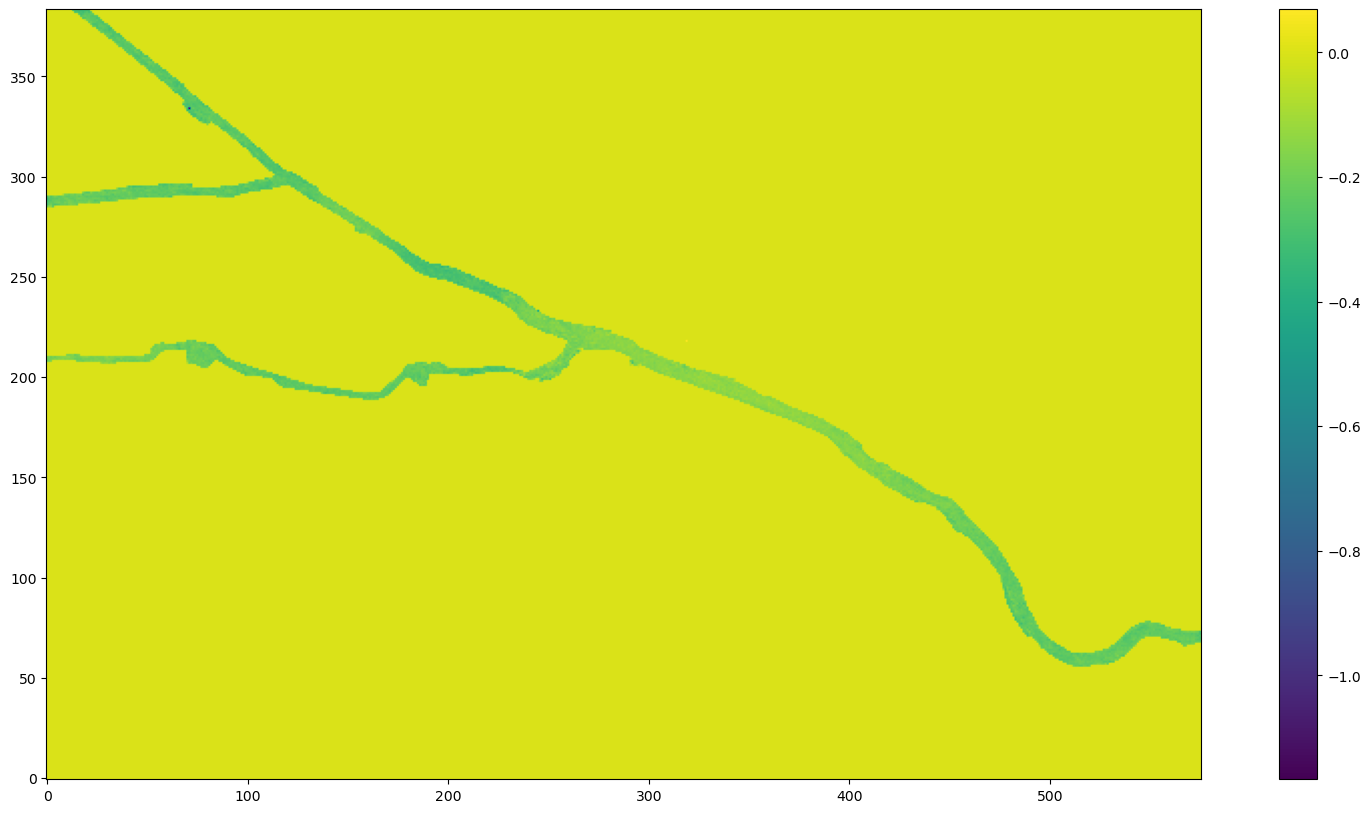

In [21]:
plt.imshow(preds[1, :, :].transpose() - vals[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

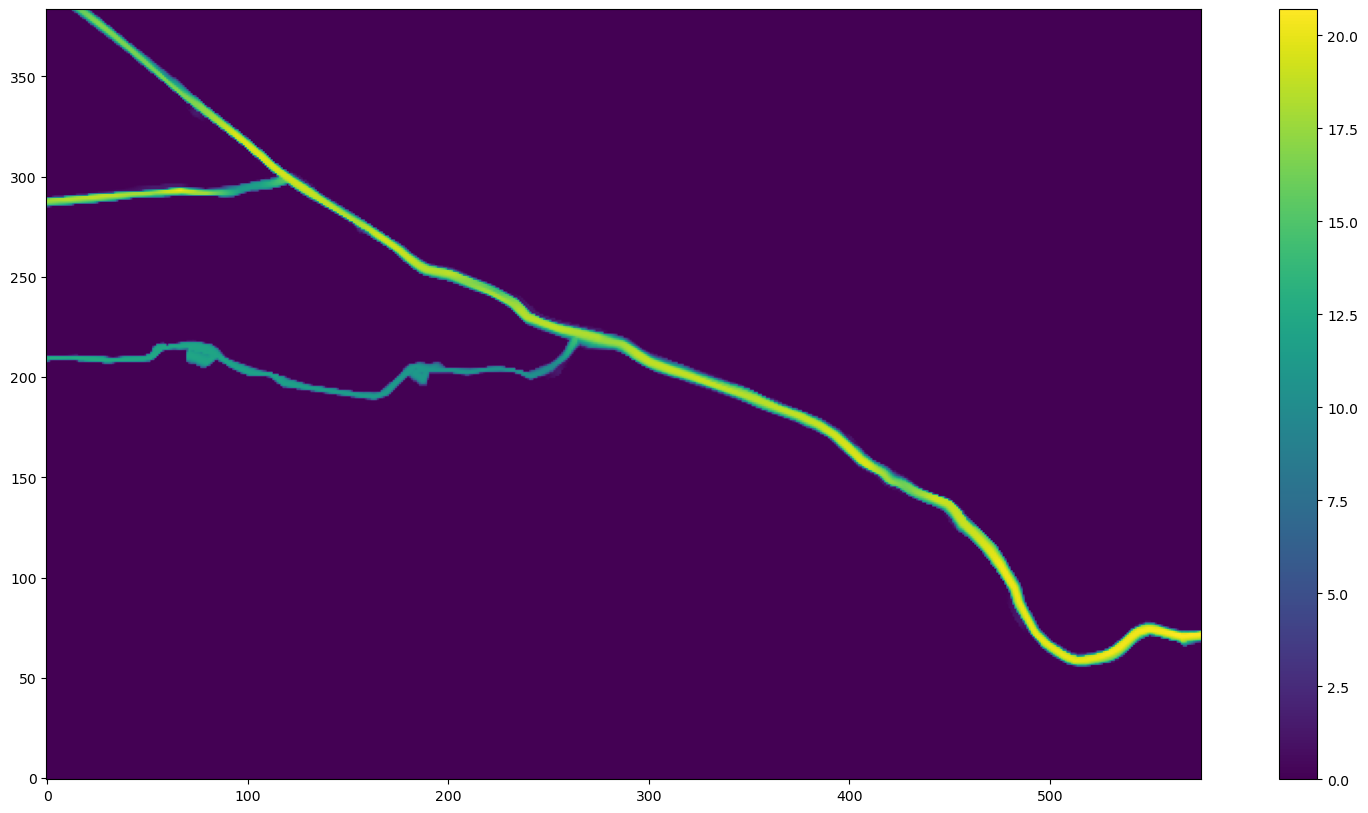

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

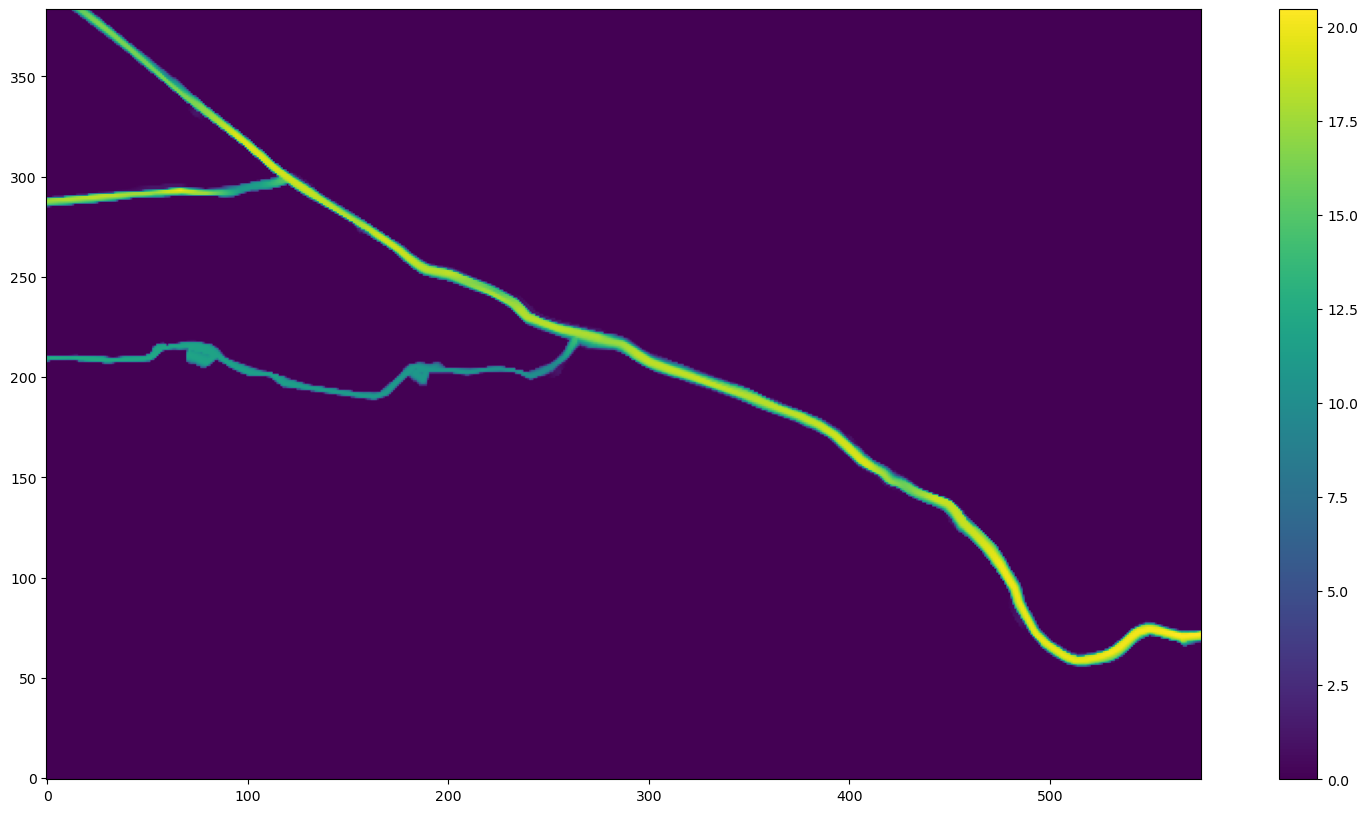

In [23]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

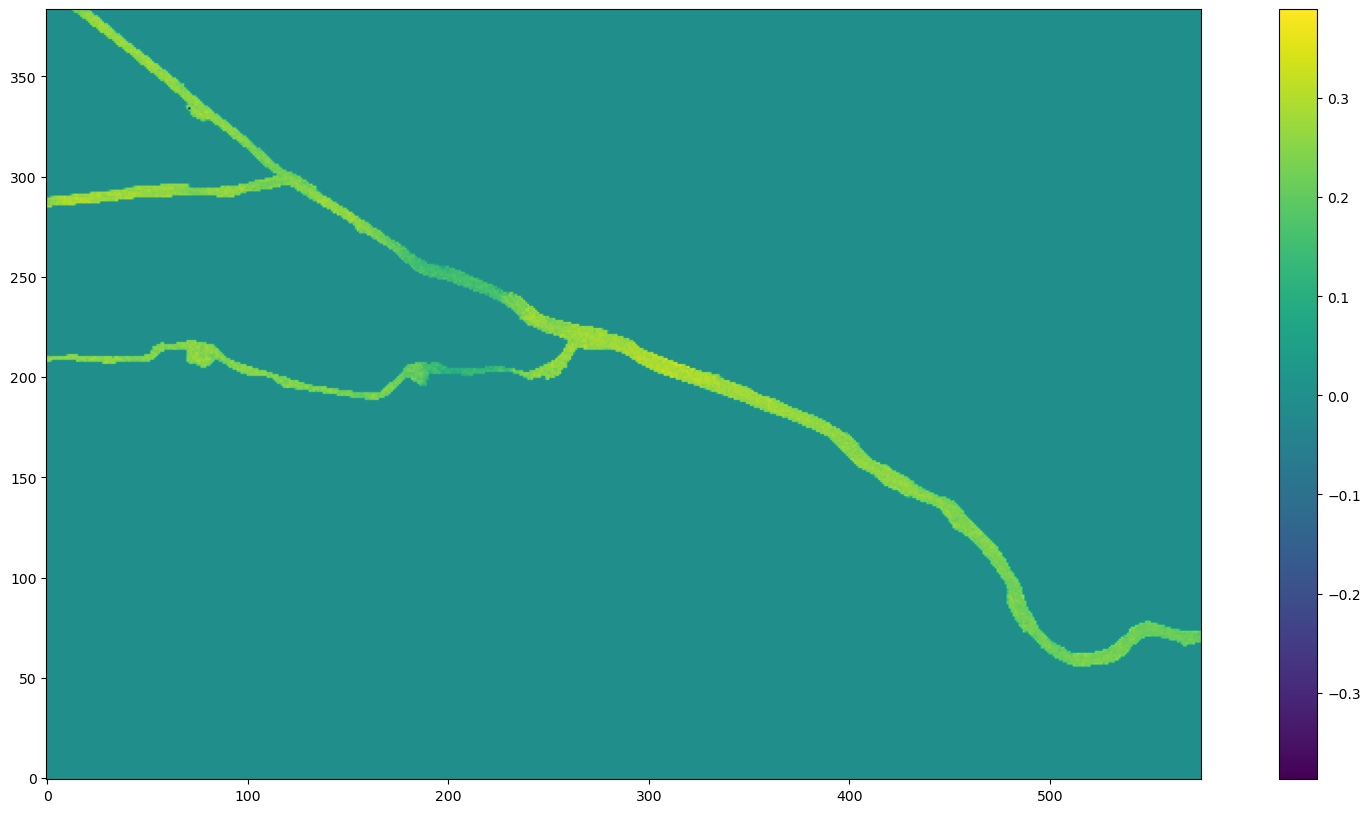

In [24]:
plt.imshow(preds[2, :, :].transpose() - vals[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

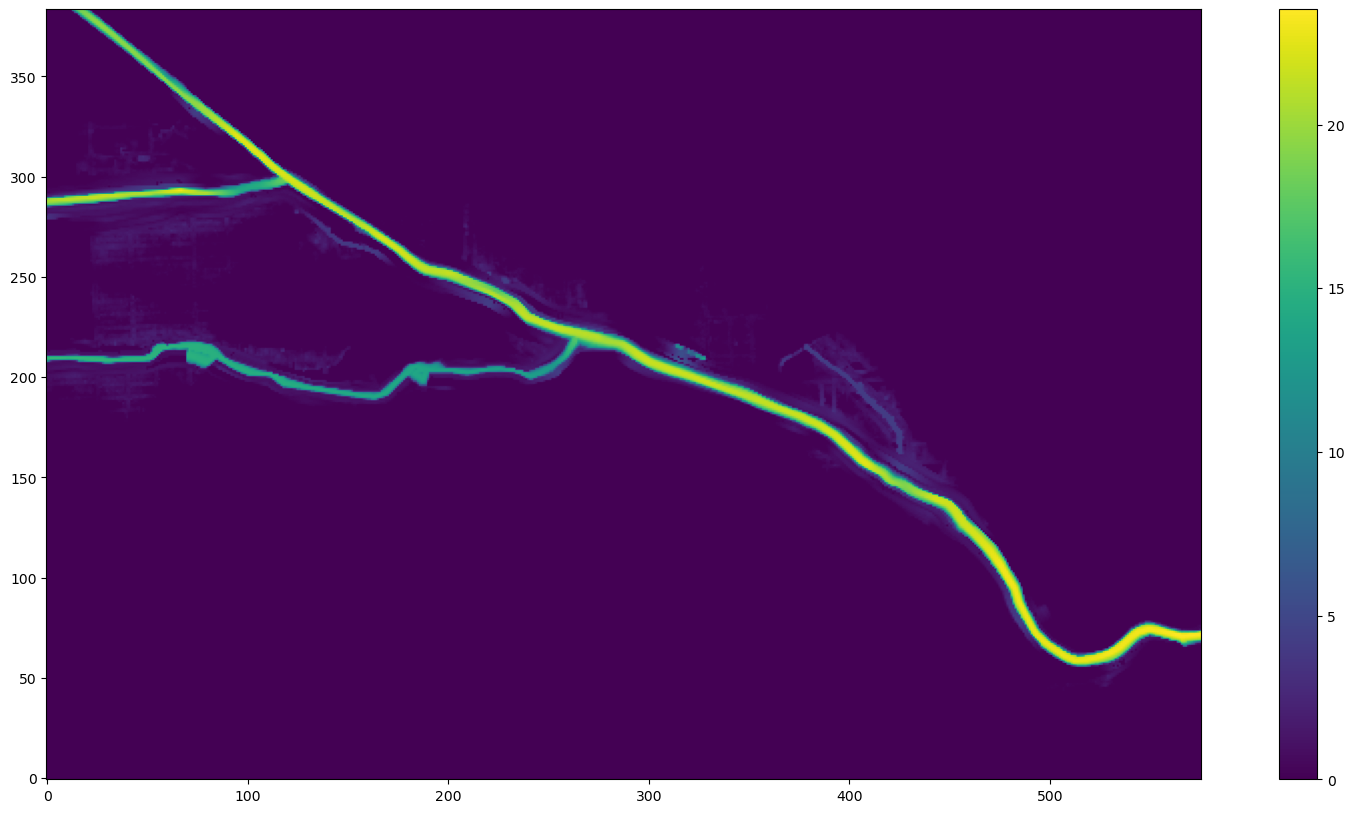

In [25]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

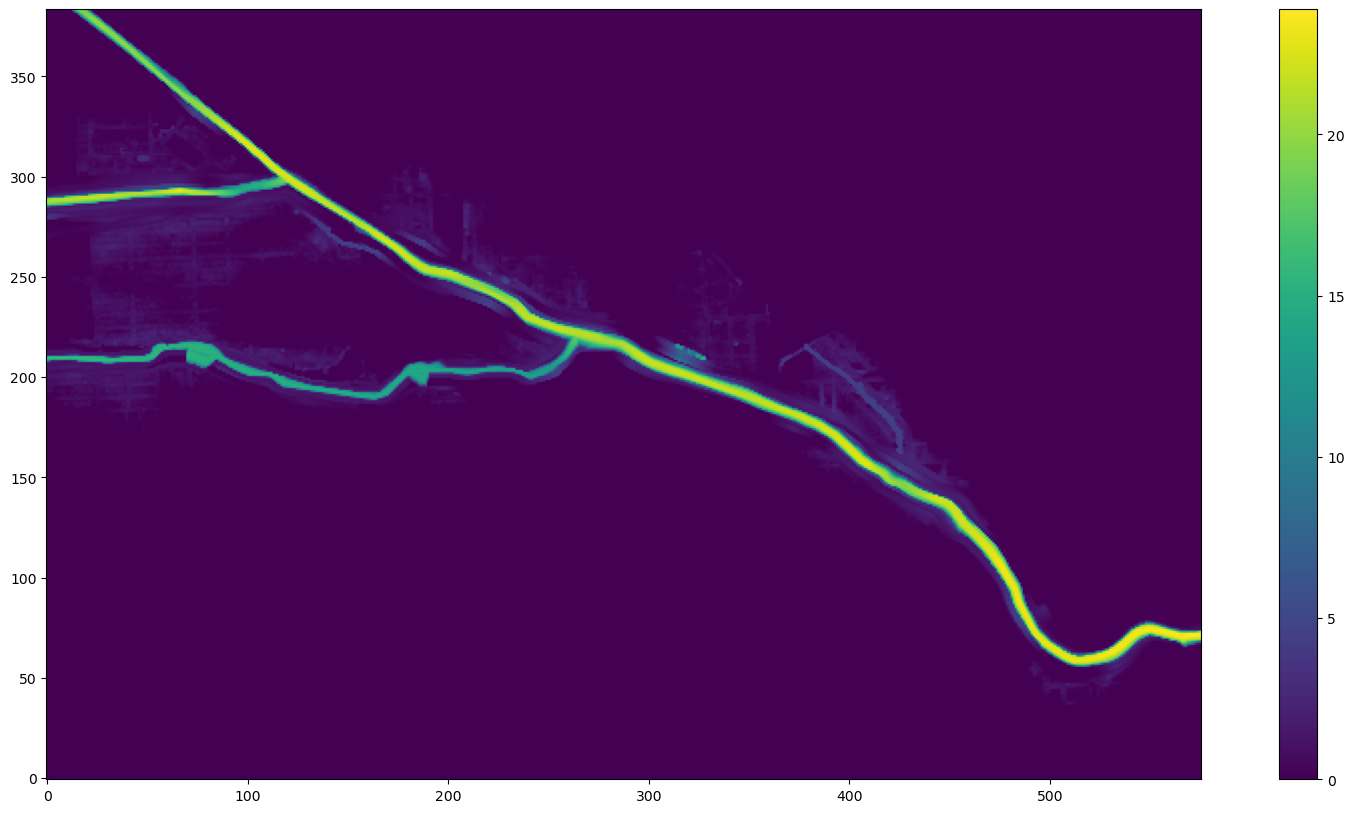

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

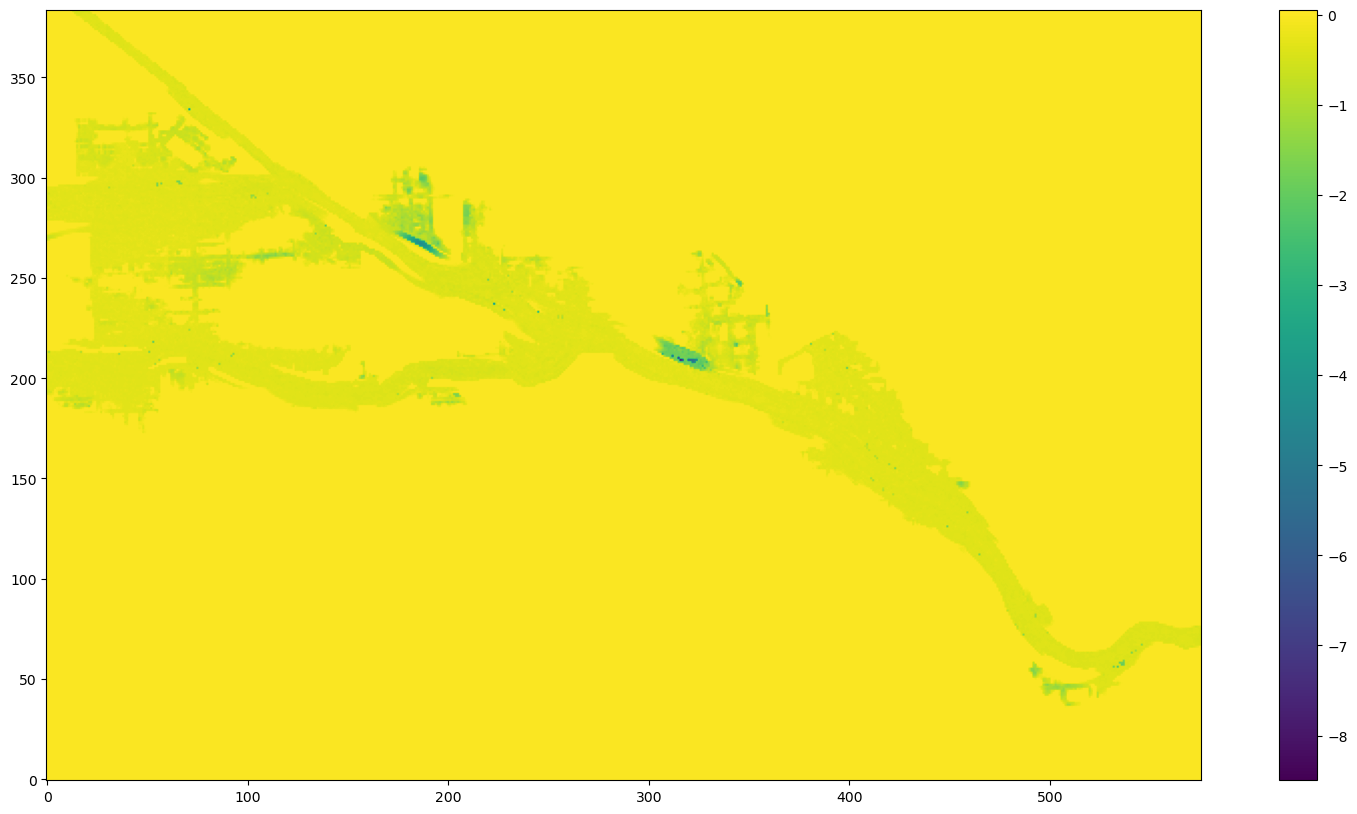

In [27]:
plt.imshow(preds[3, :, :].transpose() - vals[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

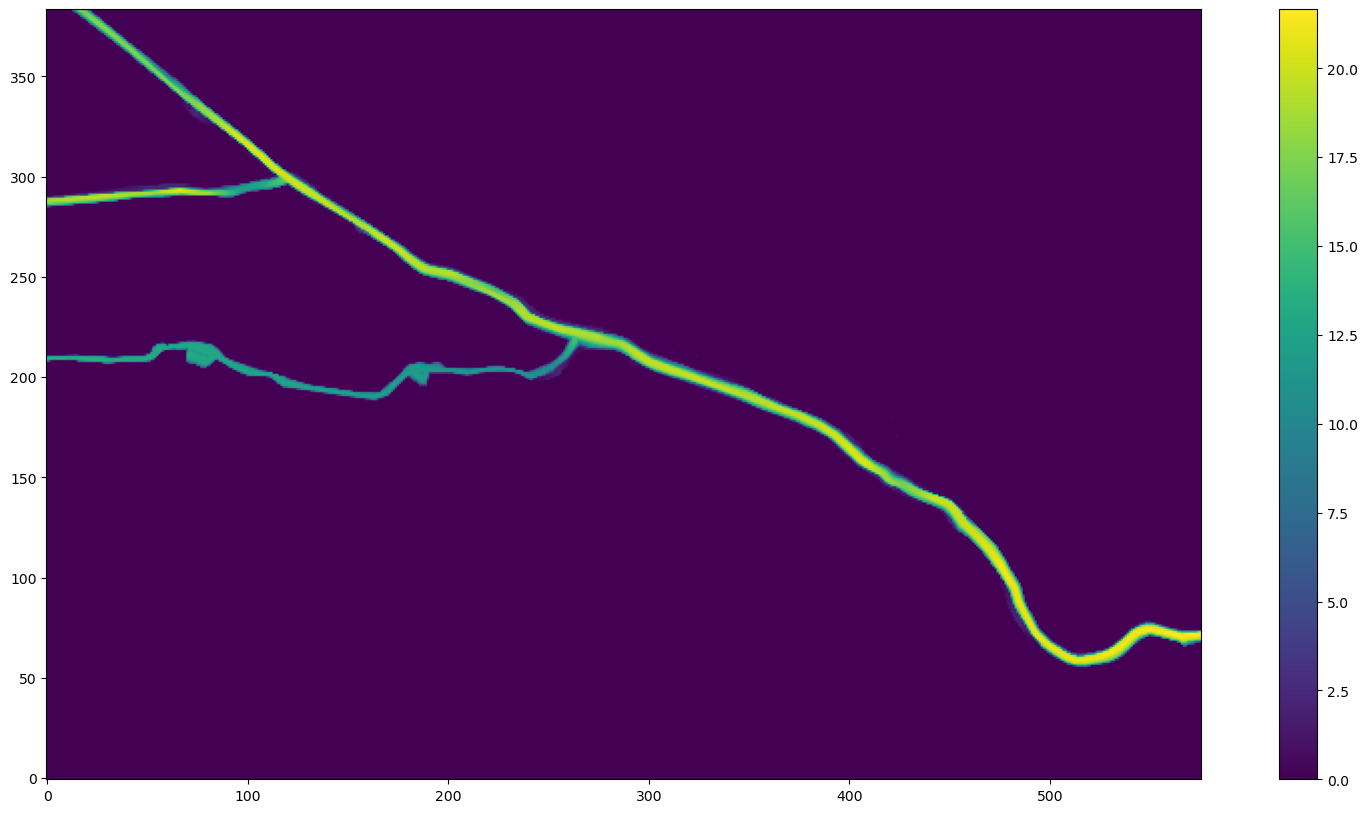

In [28]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

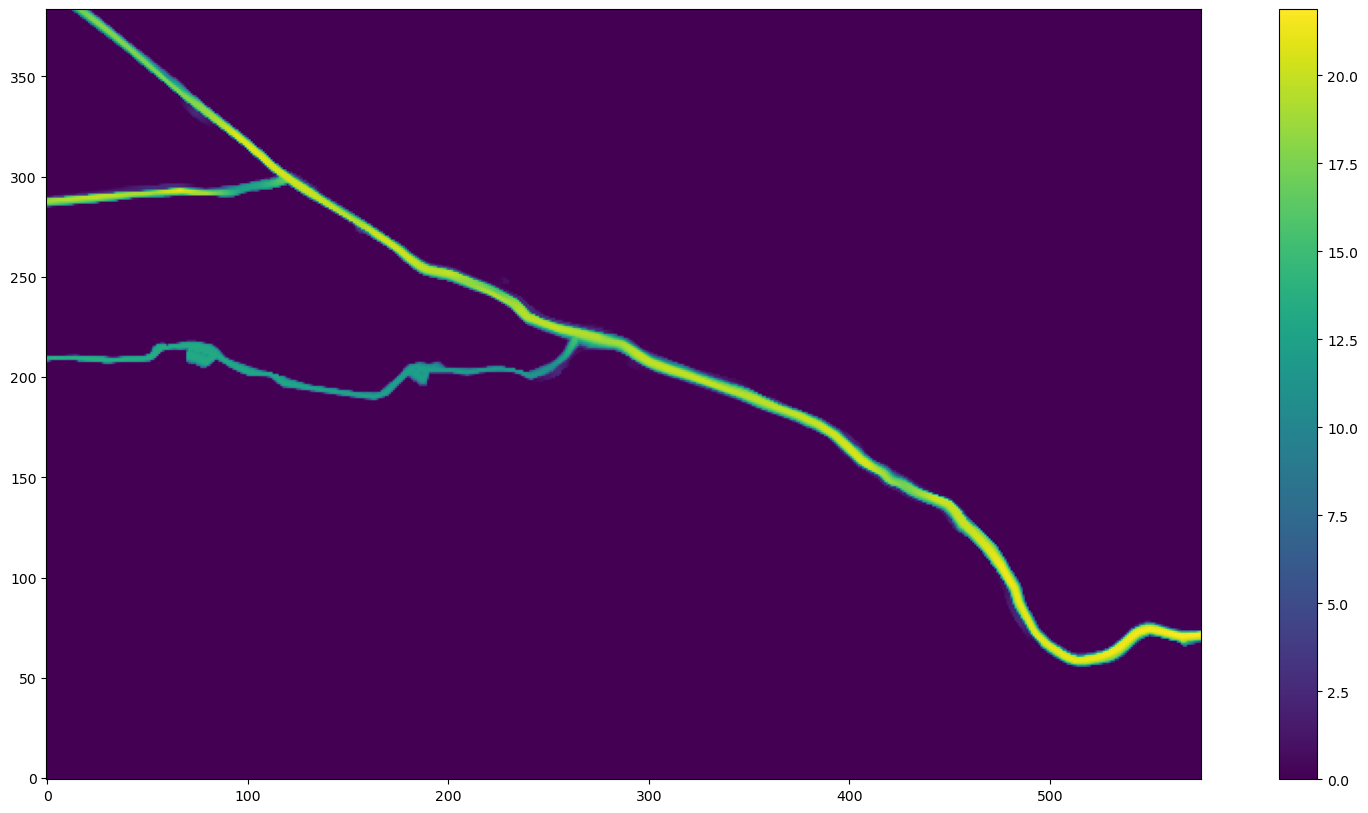

In [29]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

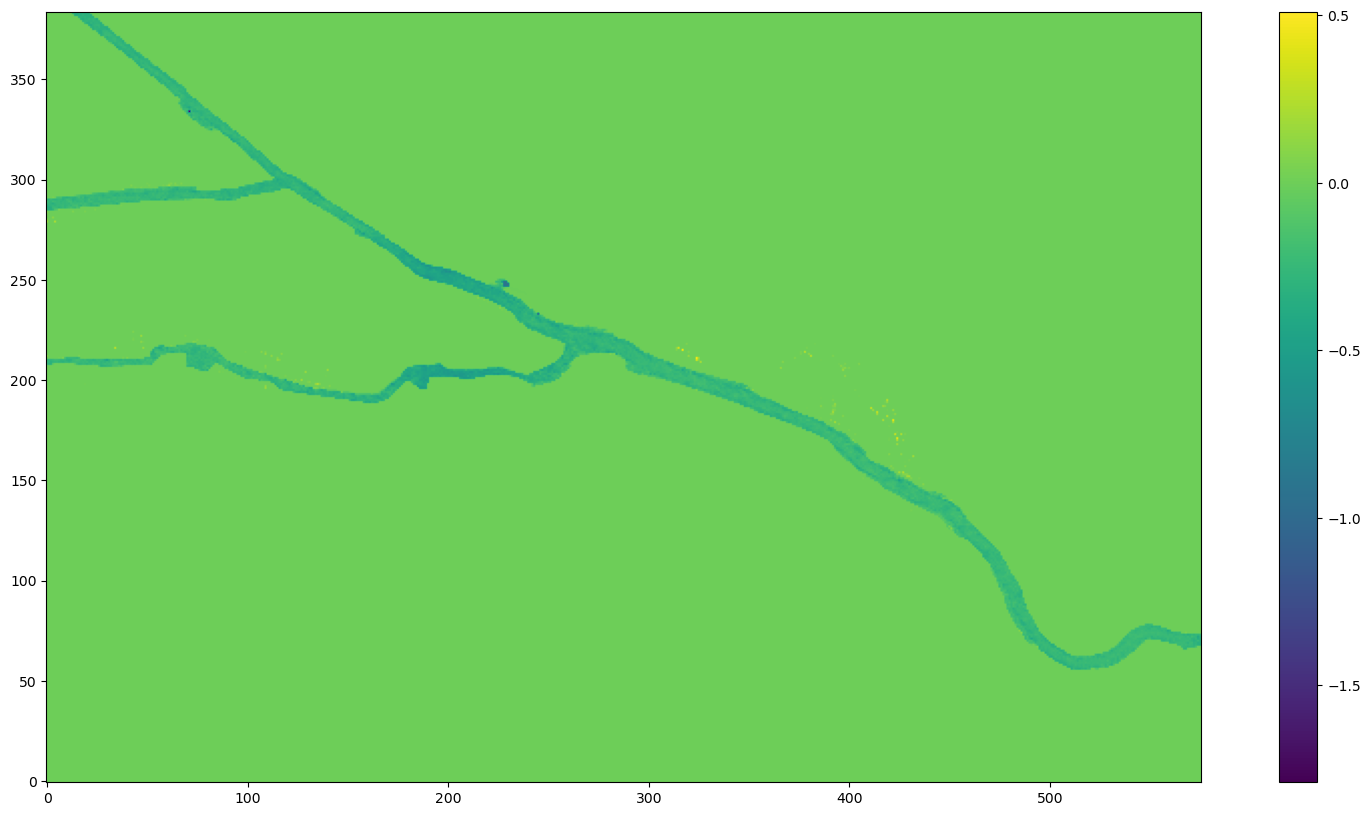

In [30]:
plt.imshow(preds[4, :, :].transpose() - vals[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

In [31]:
torch.save(model.state_dict(), 'Saved models/0SA1+Unet2048')

In [32]:
savfig_p = np.reshape(preds, (5, 576*384))
savfig_t = np.reshape(vals, (5, 576*384))

savfig_p = pd.DataFrame(savfig_p)
savfig_t = pd.DataFrame(savfig_t)

savfig_p.to_csv('CSVs/0SA1+Unet2048.csv', index=False)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df1, df2):
    return {'mae' : mean_absolute_error(df1, df2),
            'rmse' : mean_squared_error(df1, df2) ** 0.5,
            'r2' : r2_score(df1, df2)}

In [34]:
result_metrics = calculate_metrics(savfig_t, savfig_p)
result_metrics

{'mae': 0.018189805, 'rmse': 0.09103751615106172, 'r2': 0.942956486350215}